# Run GLM for each subject in parallel
**[Contributors: James Antony](#contributions)**   

### Goal of this script
 1. Run GLM w/ data scrubbing, output for GLM_xsub.ipynb

### Steps of this script
 1. Create design matrix w/ outputs from MATLAB and confound regressors in ImpConcat.ipynb
     - plot each model for visualization, including Fig 5B and S4
 2. Scrub data using framewise displacement output from ImpConcat.ipynb
 3. Load fMRI data from select ROIs
 4. Train GLM and save / output for GLM_xsub

In [6]:
# 'ipynby' is how I switch between running in jupyter notebooks and on our computing cluster. 
# see .sh files like GLM_batch, which calls GLM_srun, to see jargon for running in parallel. 
ipynby=1 #python notebook or not
if ipynby==0: #jargon for // scripting
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-subject', type=str)
    args = parser.parse_args()
    print(args.subject)
    subject=args.subject
elif ipynby==1: #if local
    subject=1
if len(str(subject))==1:
    sub ='sub-0'+str(subject)
else:
    sub ='sub-'+str(subject)
subS = str(int(subject))
ses = 'ses-01'
task='view'
n_trunc=3 # Number of volumes to trim/truncate]#
hrshiftval=5 # #volumes to shift for HMM analyses
filtcutoff=140 #high-filter cutoff
ROIs = ['NAcc','VTA2']#,'DS','RPE_Cb'
nR=len(ROIs)
print(sub)
naccroi=0
vta2roi=1
fact4y=1 #1=use 4-factor model,0=use KP ratings
rerunrois='' #'' if don't rerun, otherwise '9' or something to rerun it
reg_model=2 #1=main model with just surprise,2=bc vs bic surprise

sub-01


In [7]:
#import packages
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
import os.path
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
from nilearn.image.image import mean_img
from scipy import stats
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.cluster import KMeans
from brainiak import image, io
#import seaborn as sns 
import scipy.io
import scipy.linalg as spla
if ipynby==1:
    import matplotlib.pyplot as plt 
    %matplotlib inline 
    %autosave 30

Autosaving every 30 seconds


In [8]:
#load other necessary pre-sets
from ss_utils import load_ss_epi_data, load_ss_mask, mask_data, load_data
from ss_utils import ss_dir, ss_bids_dir, ss_TR, ss_hrf_lag, run_names, n_runs
results_path=ss_bids_dir+'derivatives/secondlevel/'
print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')
n_runs_view = n_runs[task_index]
ent_col=19 #entropy row in design matrix #16
sur_col=5
out_dir= ss_bids_dir + 'derivatives/firstlevel/%s/' % sub
analysis_dir=ss_dir+'analysis/'
#'d_event_mat' contains design matrix data that have already been convolved w/ HRF
if fact4y:
    mat_fname=analysis_dir+'d_event_mat1' 
else:
    mat_fname=analysis_dir+'d_event_mat0' 
mat_contents = scipy.io.loadmat(mat_fname)
d_mat_hrf = mat_contents['d_mat_hrf'] #design matrix for GLM
d_mat_hrf2 = mat_contents['d_mat_hrf2'] #design matrix for GLM - rescaled
unscaledd = mat_contents['d_matUS_hrf'] #design matrix for GLM - unscaled surprise
unscaledd2 = mat_contents['d_matUS_hrf2'] #design matrix for GLM - unscaled surprise
d_mat_in = mat_contents['d_mat_in'] #time-locked events that aren't convolved w/ HRF
signed_cols=np.array([4,6])#5/7 for HOME TEAM score/surprise
d_fl = mat_contents['d_fl'] #1st TR for GLM
nonfmri_dir=ss_dir+'data/nonfmri/%s/' %subS
mat_fname=nonfmri_dir+'confounds_hrf2.mat'
mat_contents = scipy.io.loadmat(mat_fname)
confounds_hrf = mat_contents['confounds_hrf'] #movie end TRs
confounds_hrf2 = mat_contents['confounds_hrf2'] #movie end TRs
signed_hrf = mat_contents['signed_hrf'] #movie end TRs
fwdhigh_hrf = mat_contents['fwdhigh_hrf'] #movie end TRs
fwdabthr=np.sum(fwdhigh_hrf)/len(fwdhigh_hrf)
print(fwdabthr)
print(signed_hrf.shape)
print(d_mat_hrf2.shape)

TASK: view
LIST OF TASKS: ['view', 'recall']
task index: 0

0.03415061295971979
(3426, 1)
(3426, 20)


In [9]:
def rescale(x):#rescale regressors from -1 to 1
    tmin=np.min(x)
    tmax=np.max(x)
    trange=tmax-tmin
    tmid=tmin+trange/2
    x=(x-tmid)/(trange/2)
    #x=x-np.mean(x)
    return x
def rescalem(x):#demean (not in use)
    x=x-np.mean(x)
    return x
def plotdesign(data,yl,lims):#plot and save the regressor for one game
    sz=2
    f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
    ax.set_xlabel('TR')
    ax.set_ylabel(yl)
    plt.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(data,'k')
    if lims:
        ax.set_ylim([-36,36])
    fign=ss_dir+'pics/GLM-%s-%s.svg' %(yl,hrshiftval)
    f.savefig(fign)

## set and plot regressors

(3426, 20)
(3426, 1)
(3426,)
(3426, 23)
(3426, 24)


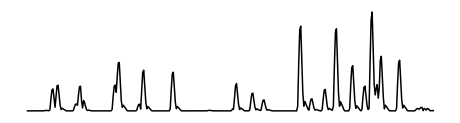

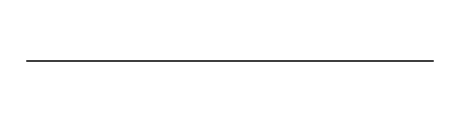

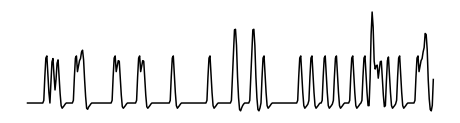

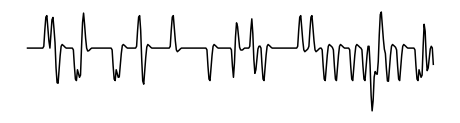

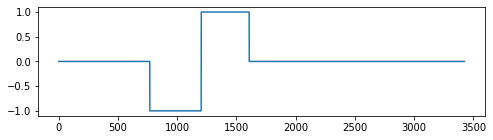

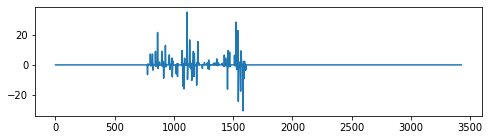

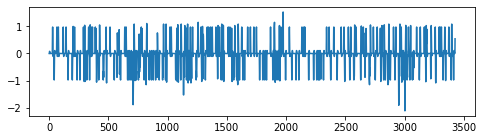

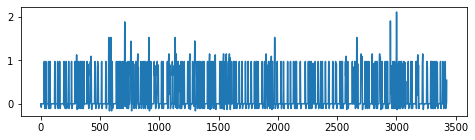

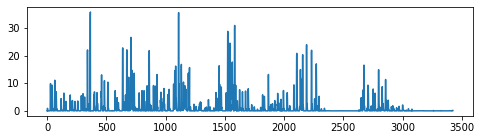

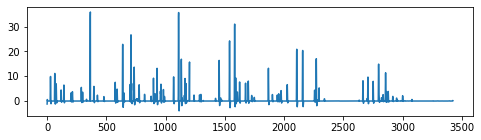

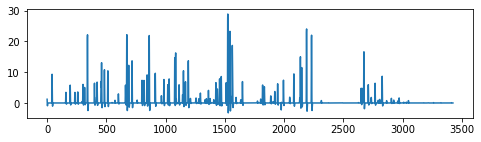

In [10]:
print(d_mat_hrf.shape)
print(signed_hrf.shape)
surprise_signed=np.zeros((signed_hrf.shape[0],signed_hrf.shape[1]))
surprise_signed[:,0]=np.multiply(d_mat_hrf[:,signed_cols[1]],signed_hrf.T)
surprise_unsigned=np.zeros((signed_hrf.shape[0],signed_hrf.shape[1]))
surprise_unsigned=np.absolute(np.multiply(d_mat_hrf[:,signed_cols[1]],1))
#surprise_unsigned_ent=-d_mat_hrf[:,ent_col] #negative entropy is belief-consistency
bcsur=np.zeros((signed_hrf.shape[0]))
bcsur=(d_mat_hrf[:,sur_col]-d_mat_hrf[:,ent_col])/2
bicsur=np.zeros((signed_hrf.shape[0],signed_hrf.shape[1]))
bicsur[:,0]=(d_mat_hrf[:,sur_col]+d_mat_hrf[:,ent_col])/2
print(surprise_unsigned.shape)

#plot model for one game and save for visualization
TRlim1=370 #1st TR for sample game
TRlim2=769 #last TR for sample game
lims=0
if ipynby==1:
    yl='Unsigned surprise'
    plotdesign(surprise_unsigned[TRlim1:TRlim2],yl,lims)
    yl='Signed surprise'
    plotdesign(surprise_signed[TRlim1:TRlim2],yl,lims)
    yl='Unsigned, unscaled surprise'
    plotdesign(unscaledd[TRlim1:TRlim2,5],yl,lims)
    yl='Signed, unscaled surprise'
    plotdesign(unscaledd[TRlim1:TRlim2,6],yl,lims)
    sz=2
    f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
    ax.plot(signed_hrf)
    f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
    ax.plot(surprise_signed)
    f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
    ax.plot(unscaledd[:,signed_cols[1]].T)
    f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
    ax.plot(unscaledd[:,5].T)
    if reg_model==2:
        f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
        ax.plot(surprise_unsigned)
        f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
        ax.plot(bcsur)
        f, ax = plt.subplots(1,1, figsize=(sz*4,sz))
        ax.plot(bicsur)
        #ax.yl('BIC sur')
    
nonzero_signed_TRs=np.sum(np.absolute(signed_hrf)) #number of signed TRs
#update design matrix
surprise_signed=rescale(surprise_signed)
d_mat_hrf2[:,signed_cols[1]]=surprise_signed.T
d_mat_hrf[:,signed_cols[1]]=surprise_signed.T
if reg_model==1:
    d_mat_hrf2[:,signed_cols[1]-1]=surprise_unsigned #JWA 5-26-20
    d_mat_hrf[:,signed_cols[1]-1]=surprise_unsigned
    print(d_mat_hrf.shape)
    d_mat_hrf2_1=np.hstack([d_mat_hrf,unscaledd[:,5:7]]) #add unscaled, unsigned + signed surprise
elif reg_model==2:
    d_mat_hrf2[:,signed_cols[1]-1]=bcsur #assign unsigned surprise to bc surprise
    d_mat_hrf[:,signed_cols[1]-1]=bcsur
    d_mat_hrf2_1=np.hstack([d_mat_hrf,unscaledd[:,5:7]]) #add unscaled, unsigned + signed surprise
    d_mat_hrf2_1=np.hstack([d_mat_hrf2_1,bicsur]) #add belief-inconsistent surprise to end

#d_mat_hrf2_1=np.hstack([d_mat_hrf2,unscaledd2[:,5:7]]) #add unscaled, unsigned + signed surprise #JWA 5-26-20
print(d_mat_hrf2_1.shape)
fwdfill=confounds_hrf[:,6:7]
d_mat_hrf3=np.hstack([d_mat_hrf2_1,fwdfill]) #add frame-wise displacement last
print(d_mat_hrf3.shape)

## data scrubbing using frame-wise displacement threshold (fwdhigh_hrf)

-0.018033794803686637


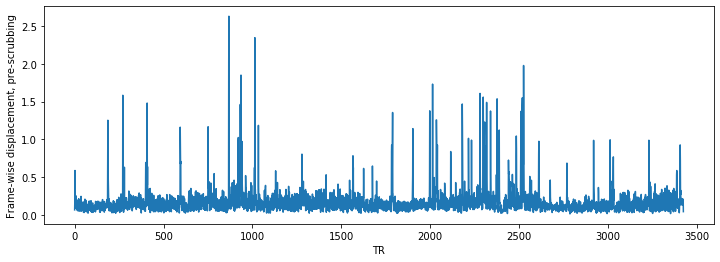

In [22]:
#is fwd correlated w/ surprise? (must use non-convolved design matrix)
fwdsur,p=stats.pearsonr(d_mat_in[:,5],confounds_hrf[:,6])
fwdent,p=stats.pearsonr(d_mat_in[:,ent_col],confounds_hrf[:,6])
print(fwdsur)
if ipynby==1: #plot FWD
    f, ax = plt.subplots(1,1, figsize=(sz*6,sz*2))
    ax.plot(confounds_hrf[:,6:7]) #FWD in full
    ax.set_xlabel('TR')
    ax.set_ylabel('Frame-wise displacement, pre-scrubbing')

2844
(3426, 1)
(3426, 1)
(2844, 24)


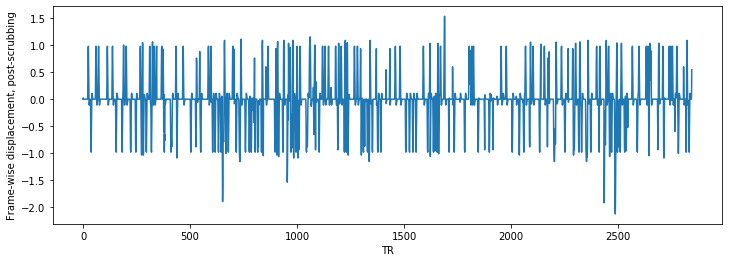

In [23]:
sel=np.ones((d_mat_hrf3.shape[0],1))
sel2=np.ones((d_mat_hrf3.shape[0],1))
sel_epi=fwdhigh_hrf!=1

#scrub data by removing problematic TRs
for tr in range(0,d_mat_hrf3.shape[0]): #now flag also 1 TR before and 2 TR after
    if fwdhigh_hrf[tr]==1: #if above threshold
        sel[tr]=0 #find fwd > thresh
        sel2[tr]=0
        sel_epi[tr]=False
        if tr>0: 
            sel2[tr-1]=0 #scrub back 1 TR
            sel_epi[tr-1]=False
        if tr<fwdhigh_hrf.shape[0]-2:
            sel2[tr+2]=0 #scrub forward 1-2 TRs
            sel_epi[tr+2]=False
        if tr<fwdhigh_hrf.shape[0]-1:
            sel2[tr+1]=0
            sel_epi[tr+1]=False
            
print(int(sum(sel2)))
d_mat_hrf4=np.zeros((int(sum(sel2)),d_mat_hrf3.shape[1]))
j=0
jj=0
for tr in range(0,d_mat_hrf3.shape[0]): 
    if sel2[tr]==1:
        d_mat_hrf4[j,:]=d_mat_hrf3[tr,:]
        j=j+1
    
print(sel_epi.shape)
print(sel2.shape)
print(d_mat_hrf4.shape)
if ipynby==1:
    f, ax = plt.subplots(1,1, figsize=(sz*6,sz*2))
    ax.plot(d_mat_hrf4[:,21]) #FWD, scrubbed 
    ax.set_xlabel('TR')
    ax.set_ylabel('Frame-wise displacement, post-scrubbing')

## create final design matrices

In [24]:
qq1=d_mat_hrf4[:,1:3] #game remaining, home possession
qq2=d_mat_hrf4[:,12:17] #auditory env, luminance, visual motion, prosody (15), court pos (incl 16!)
if reg_model==1:
    qq3=d_mat_hrf4[:,22:23] #framewise displacement
elif reg_model==2:
    qq3=d_mat_hrf4[:,23:24] #framewise displacement
qq4=d_mat_hrf4[:,5:6] #unsigned surprise or if reg_model==2, bc sur
qq5=d_mat_hrf4[:,6:7] #signed surprise
#qq5=-d_mat_hrf4[:,ent_col:ent_col+1] #negative entropy = belief-consistency
if reg_model==1:
    qq6=d_mat_hrf4[:,20:22] #unscaled unsigned + unscaled signed 
elif reg_model==2:
    qq6=d_mat_hrf4[:,20:23] #unscaled unsigned + unscaled signed + bic sur
d_mat_hrf4_mass=np.hstack([qq1,qq2]) #put together
d_mat_hrf4_mass=np.hstack([d_mat_hrf4_mass,qq3])
d_mat_hrf4_mass=np.hstack([d_mat_hrf4_mass,qq4])
d_mat_hrf4_mass=np.hstack([d_mat_hrf4_mass,qq5])
d_mat_hrf4_mass=np.hstack([d_mat_hrf4_mass,qq6])

for regressor in range(d_mat_hrf4_mass.shape[1]):
    d_mat_hrf4_mass[:,regressor]=rescale(d_mat_hrf4_mass[:,regressor]) #rescalem

#for visualization
d_mat_hrf4_mass_viz=np.zeros((d_mat_hrf4_mass.shape[0],d_mat_hrf4_mass.shape[1]))
for regressor in range(d_mat_hrf4_mass.shape[1]):
    d_mat_hrf4_mass_viz[:,regressor]=rescale(d_mat_hrf4_mass[:,regressor])

#category labels for GLM
if reg_model==1:
    cats_orig_mass=["Game remaining","Home possession","Auditory env","Luminance",
                    "Visual motion","Prosody","Court position","Frame-wise displacement",
                    "Surprise","Signed surprise",
                    "Surprise, unscaled","Signed surprise, unscaled"]
elif reg_model==2:
    cats_orig_mass=["Game remaining","Home possession","Auditory env","Luminance",
                    "Visual motion","Prosody","Court position","Frame-wise displacement",
                    "Belief-consistent surprise","Signed surprise",
                    "Surprise, unscaled","Signed surprise, unscaled","Belief-inconsistent surprise"]

(2844, 13)


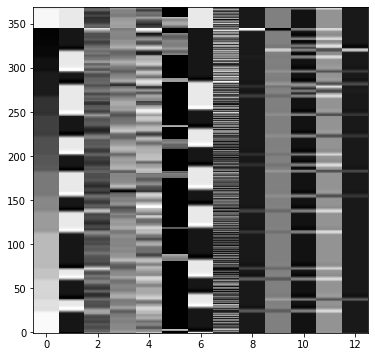

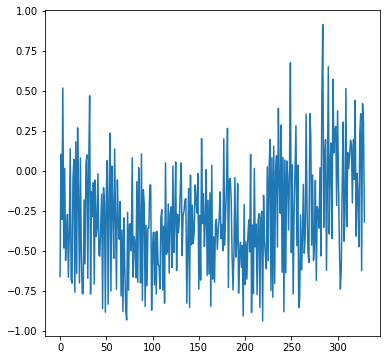

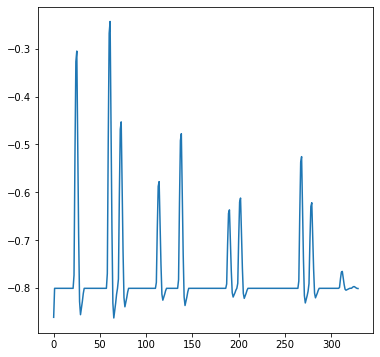

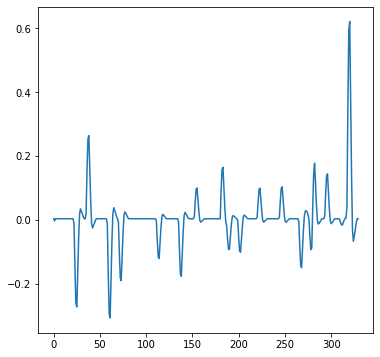

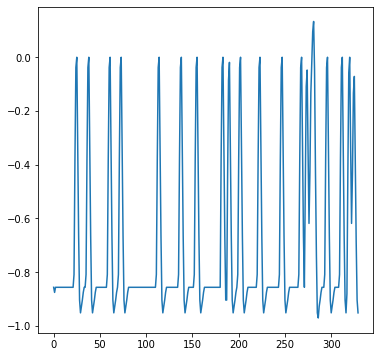

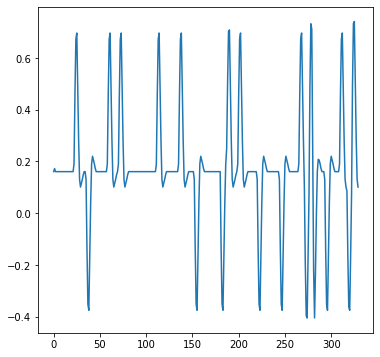

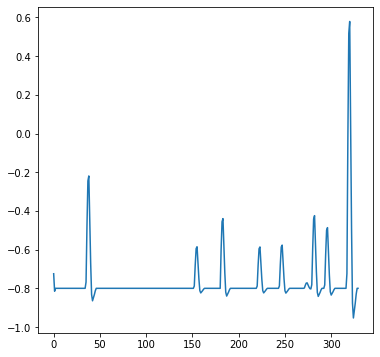

In [25]:
#visualize design matrix
if ipynby==1:
    trc=330
    f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
    ax.imshow(d_mat_hrf4_mass_viz[:TRlim1,:],cmap='gray',origin='lower',interpolation='none',aspect="auto")
    if reg_model==1:
        fwdcol=-5
    elif reg_model==2:
        fwdcol=-6
    f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
    ax.plot(d_mat_hrf4_mass[:trc,fwdcol])
    f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
    ax.plot(d_mat_hrf4_mass[:trc,fwdcol+1])
    f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
    ax.plot(d_mat_hrf4_mass[:trc,fwdcol+2])
    f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
    ax.plot(d_mat_hrf4_mass[:trc,fwdcol+3])
    f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
    ax.plot(d_mat_hrf4_mass[:trc,fwdcol+4])
    if reg_model==2:
        f, ax = plt.subplots(1,1, figsize=(sz*3,sz*3))
        ax.plot(d_mat_hrf4_mass[:trc,fwdcol+5])

print(d_mat_hrf4_mass_viz.shape)

## load fMRI data

In [26]:
print('available ROIs: ',ROIs)
epi_in = out_dir + '%s_task-view_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_%s_%s_norm_glm.nii.gz' % (sub,n_trunc,hrshiftval,filtcutoff)
epi_data = nib.load(epi_in)
print("Loading data from %s" % (epi_in))
print('epi_data shape: ', epi_data.shape)

# Make a function to load the mask data
def load_ss_masked_data(directory, subject_name, mask_list):
    masked_data_all = [0] * (len(mask_list))
    masked_coords_all = [0] * (len(mask_list))
    # Cycle through the masks
    for mask_counter in range(len(mask_list)):
        roi_fn = out_dir + '%s_task-view9%s_%s.mat' % (sub,rerunrois,ROIs[mask_counter])
        if mask_counter==0:
            roi_fn = out_dir + '%s_task-view9%s_%s.mat' % (sub,rerunrois,ROIs[mask_counter])
        if os.path.exists(roi_fn):
            roi_fn = out_dir + '%s_task-view_%s.mat' % (sub,ROIs[mask_counter])
            mat_contents = scipy.io.loadmat(roi_fn)
            epi_masked_data = mat_contents['epi_masked_data'] #design matrix for GLM
            print('File found, loading %s' % (roi_fn))
            masked_coords = mat_contents['masked_coords'] #design matrix for GLM
            if mask_counter==0:
                nacc_coords=masked_coords
            elif mask_counter==1:
                vta_coords=masked_coords
        else:
            roi_fn = out_dir + '%s_task-view_%s.mat' % (sub,ROIs[mask_counter])
            # load the mask for the corresponding ROI
            this_mask = mask_list[mask_counter]
            mask = load_ss_mask(this_mask, subject_name)
            print(mask.shape)
            masked_coords=mask.dataobj
            #masked_coords_all[mask_counter] = masked_coords
            # mask the data 
            epi_masked_data = mask_data(epi_data, mask)
            epi_masked_data = np.transpose(epi_masked_data)
            type(epi_masked_data)
            scipy.io.savemat(roi_fn,{'epi_masked_data': epi_masked_data,
                                    'masked_coords': masked_coords})
            if mask_counter==0:
                nacc_coords=masked_coords
            elif mask_counter==1:
                vta_coords=masked_coords
            
        # Check the dimensionality of the data
        print('voxel by TR matrix - shape: ', epi_masked_data.shape)
        print('')
        masked_data_all[mask_counter] = epi_masked_data
        
    return masked_data_all,nacc_coords,vta_coords

available ROIs:  ['NAcc', 'VTA2']
Loading data from /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-11/sub-11_task-view_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3_5_140_norm_glm.nii.gz
epi_data shape:  (61, 73, 61, 3426)


In [27]:
#load data w/ ROI masks
masked_data_all,nacc_coords,vta_coords = load_ss_masked_data(out_dir, sub, ROIs)

Loaded NAcc mask
(61, 73, 61)
voxel by TR matrix - shape:  (186, 3426)

Loaded VTA2 mask
(61, 73, 61)
voxel by TR matrix - shape:  (31, 3426)



(61, 73, 61)
NAcc has 186 voxels
VTA2 has 31 voxels
(186, 3426)


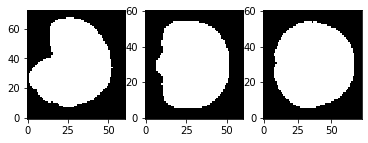

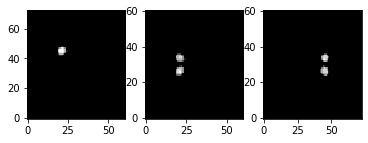

In [28]:
#some plotting things to visualize ROIs
avg_mask_name = results_path + 'avg_brain_mask.nii.gz'
#load in mask as boolean
brain_mask = io.load_boolean_mask(avg_mask_name)# Load the brain mask
coords = np.where(brain_mask)# Get the list of nonzero voxel coordinates
brain_nii = nib.load(avg_mask_name)# Load the brain nii image
print(nacc_coords.shape)
xmidpt=((nacc_coords.shape[0]-1)/2)+1
ymidpt=((nacc_coords.shape[1]-1)/2)+1
zmidpt=((nacc_coords.shape[2]-1)/2)+1

if ipynby==1:
    f, ax = plt.subplots(1,3, figsize=(6,2))
    ax[0].imshow(brain_nii.dataobj[xmidpt,:,:],cmap='gray',origin='lower',interpolation='none',aspect="auto")
    ax[1].imshow(brain_nii.dataobj[:,ymidpt,:],cmap='gray',origin='lower',interpolation='none',aspect="auto")
    ax[2].imshow(brain_nii.dataobj[:,:,zmidpt],cmap='gray',origin='lower',interpolation='none',aspect="auto")
    f, ax = plt.subplots(1,3, figsize=(6,2))
    ax[0].imshow(np.mean(nacc_coords,axis=0),cmap='gray',origin='lower',interpolation='none',aspect="auto")
    ax[1].imshow(np.mean(nacc_coords,axis=1),cmap='gray',origin='lower',interpolation='none',aspect="auto")
    ax[2].imshow(np.mean(nacc_coords,axis=2),cmap='gray',origin='lower',interpolation='none',aspect="auto")
    
for roi in range(nR): #check # voxels for ROIs
    print("%s has %s voxels" % (ROIs[roi],masked_data_all[roi].shape[0]))

print(masked_data_all[0].shape)

## Train the regression model

In [29]:
#pre-assign variables
r_coef_mass_mean=np.zeros((nR,d_mat_hrf4_mass.shape[1]))
xcoords=np.zeros((masked_data_all[0].shape[0])) #NAcc xcoords
xcoordsvta=np.zeros((masked_data_all[1].shape[0])) #NAcc xcoords
xmidpt=((nacc_coords.shape[0]-1)/2)+1
for roi in range(nR): #loop through ROIs
    voxel_ids = masked_data_all[roi].shape[0] # #voxels
    start = time.time() #log time
    r_coef_mass=np.zeros((d_mat_hrf4_mass.shape[1],voxel_ids))
    if roi==0:
        q2=nacc_coords[:,:,:]==1
        q3=np.where(q2)
        xcs=np.abs(q3[0]-xmidpt)
    elif roi==1:
        q2=vta_coords[:,:,:]==1
        q3=np.where(q2)
        xcsvta=np.abs(q3[0]-xmidpt)
    for voxel_id in range(voxel_ids): #loop through voxels w/in ROI
        if roi==0:
            xcoords[voxel_id]=xcs[voxel_id]
        elif roi==1:
            xcoordsvta[voxel_id]=xcsvta[voxel_id]
        #mass GLM
        regr = linear_model.LinearRegression() #set up model
        dat=masked_data_all[roi][voxel_id,sel_epi[:,0]] #fMRI data
        ones_m=np.ones((d_mat_hrf4_mass.shape[0],1)) #add ones column
        new_r=np.hstack([ones_m,d_mat_hrf4_mass]) #final design matrix
        mask = []
        mask = ~np.isnan(dat) & ~np.isinf(dat) 
        regr.fit(new_r[mask,:],dat[mask]) #fit model
        r_coef_mass[:,voxel_id]=regr.coef_[1:] #assign coefficients after ones column
        
    end = time.time()
    print(end - start) #print time it took for this ROI
    #save all individual beta values
    if roi==0:
        r_coef_nacc_mass=r_coef_mass 
    elif roi==1:
        r_coef_vta_mass=r_coef_mass
    #grab average coefficients
    for xsel in range(d_mat_hrf4_mass.shape[1]):    
        r_coef_mass_mean[roi,xsel]=np.mean(r_coef_mass[xsel,:])

0.35833191871643066
0.06577801704406738


In [30]:
#grab average activity within ROI across time (unused)
masked_data_avg=np.zeros((masked_data_all[0].shape[1],nR)) 
for roi in range(nR):
    aa=np.mean(masked_data_all[roi][:,:],axis=0)
    masked_data_avg[:,roi]=aa
    if roi==0:
        masked_data_nacc=masked_data_all[roi]
    elif roi==1:
        masked_data_vta=masked_data_all[roi]
print(masked_data_avg.shape)
print('beta coefficients for all: %s' %r_coef_mass_mean)

(3426, 2)
beta coefficients for all: [[-0.01240294 -0.00466962  0.00460142 -0.00072647  0.01074854 -0.00573664
   0.02983326  0.08623954  0.06802179  0.09667146 -0.15521937  0.01480233
   0.0961549 ]
 [-0.00244454  0.03305645  0.00951566 -0.05546576  0.06306899  0.00065339
   0.01654137  0.1523685   0.05132046 -0.02925931 -0.00582278  0.07374918
   0.04097518]]


In [31]:
#save, output for GLM_XSub
mat_fname=out_dir+'glm_out-%s-%s-%s-%s-%s.mat' %(n_trunc,hrshiftval,filtcutoff,fact4y,reg_model)
scipy.io.savemat(mat_fname,{'r_coef_mass_mean':r_coef_mass_mean,'r_coef_nacc_mass':r_coef_nacc_mass,
                            'r_coef_vta_mass':r_coef_vta_mass,'cats_orig_mass': cats_orig_mass,
                            'fwdabthr': fwdabthr,'masked_data_avg': masked_data_avg,
                            'masked_data_nacc': masked_data_nacc,'masked_data_vta': masked_data_vta,
                            'fwdsur':fwdsur,'fwdent':fwdent,'nonzero_signed_TRs':nonzero_signed_TRs,
                            'sel_epi': sel_epi,'xcoords':xcoords,'xcoordsvta':xcoordsvta})

In [32]:
print(mat_fname) #print (for output file)

/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-11/glm_out-3-5-140-1-2.mat
